In [1]:
import os
import numpy as np
import numpy.ma as ma

import xarray as xr
import pandas as pd

import netCDF4
from netCDF4 import Dataset, num2date

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import datetime as dt
from dateutil.relativedelta import *

import cmocean

from matplotlib import pyplot as plt
#%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
name = 'Yule'
reef_Gnet = xr.open_dataset(f'Reef-Data/{name}_reef.nc')
# reef_Gnet = reef_Gnet.to_dataframe()
reef_Gnet = reef_Gnet[['Gnet']]

gb = reef_Gnet.groupby('time.month')
gb

gb = reef_Gnet.groupby('time.month')

ds_anom = gb - gb.mean(dim='time')
ds_anom

ds_anom_rolling = ds_anom.rolling(time=12, center=True).mean()
ds_anom_rolling


# plt.title(f'{name} Reef Gnet Anomalies')
# plt.xlabel('Time')
# plt.ylabel('Gnet (mg/m-2/day)')
# plt.bar(ds_anom_rolling['time'], ds_anom_rolling['Gnet'],
#         color=np.where(ds_anom_rolling['Gnet'] < 0, 'r', 'b'))
# plt.xticks(rotation=45)
# plt.tight_layout() 
# plt.savefig(f'{name}-anom.png')



<xarray.Dataset>
Dimensions:  (time: 1122)
Coordinates:
  * time     (time) datetime64[ns] 2016-11-01 2016-11-02 ... 2019-11-28
    month    (time) int64 11 11 11 11 11 11 11 11 11 ... 11 11 11 11 11 11 11 11
Data variables:
    Gnet     (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [16]:
import pandas as pd

gnet = pd.read_csv('Reef_Scatter.csv')

gnet = gnet[['Sector', 'change (grams/m^2/day)']]

from scipy.stats import sem

groups = gnet.groupby('Sector').sem().reset_index()

groups

,Sector,change (grams/m^2/day)
0,Central,0.172166
1,Northern,0.150935
2,Southern,1.283331


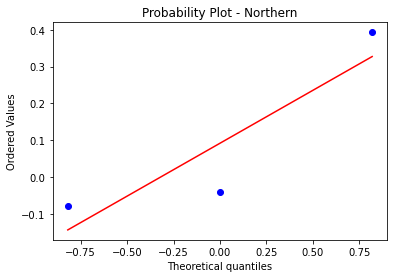

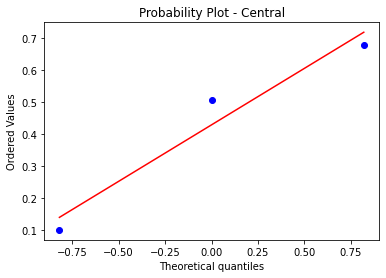

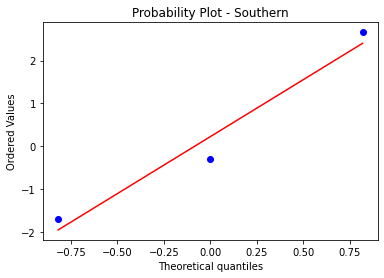

In [4]:

import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt

unique_sector = gnet['Sector'].unique()
for Sector in unique_sector:
    stats.probplot(gnet[gnet['Sector'] == Sector]['change (grams/m^2/day)'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  Sector)
    plt.show()

In [5]:
ratio = gnet.groupby('Sector').std().max() / gnet.groupby('Sector').std().min()
ratio

change (grams/m^2/day)    8.502565
dtype: float64

In [6]:

# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = gnet['change (grams/m^2/day)'].mean()
SSTR = gnet.groupby('Sector').count() * (gnet.groupby('Sector').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['change (grams/m^2/day)'].sum()

# calculate SSE and update anova table
SSE = (gnet.groupby('Sector').count() - 1) * gnet.groupby('Sector').std()**2
anova_table['SS']['Within Groups'] = SSE['change (grams/m^2/day)'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['change (grams/m^2/day)'].sum() + SSE['change (grams/m^2/day)'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = gnet['Sector'].nunique() - 1
anova_table['df']['Within Groups'] = gnet.shape[0] - gnet['Sector'].nunique()
anova_table['df']['Total'] = gnet.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,0.172572,2,0.086286,0.050775,0.950896,7.259856
Within Groups,10.196165,6,1.699361,,,
Total,10.368737,8,1.296092,,,
